In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_epochs = 5
total_series_length = 10000
truncated_backprop_length = 15
state_size = 4
batch_size = 1
num_batches = total_series_length//batch_size//truncated_backprop_length

In [3]:
def generate_data(length):
    x = np.linspace(0,length, length*10+1)
    y = 10*np.sin(x).reshape(1,-1)
    return(y)

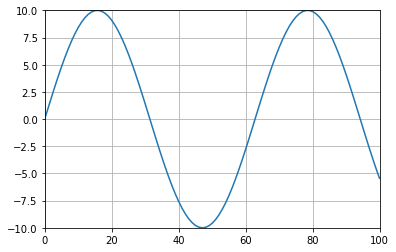

In [4]:
line_data = generate_data(10)
fig, ax = plt.subplots()
ax.plot(line_data.reshape(-1))
ax.grid(True)
ax.axis([0,100,-10,10])
plt.show()

In [5]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W2 = tf.Variable(np.random.rand(state_size, 1),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1)), dtype=tf.float32)

inputs_series = tf.split(axis=1, num_or_size_splits=truncated_backprop_length, value=batchX_placeholder)
#labels_series = batchY_placeholder
labels_series = tf.unstack(batchY_placeholder)

In [6]:
cell = tf.contrib.rnn.BasicRNNCell(state_size)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

In [11]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series]
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

#losses = [tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
losses = tf.reduce_sum(tf.square(labels - logits) for logits, labels in (logits_series,labels_series))
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.001).minimize(total_loss)

TypeError: Expected binary or unicode string, got <generator object <genexpr> at 0x7f80477bf730>

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    #plot_data_y = np.array([])
    loss_list = []

    x_data = generate_data(total_series_length)
    _current_state = np.zeros((batch_size, state_size))

    for batch_idx in range(num_batches):
        start_idx = batch_idx
        end_idx = start_idx + truncated_backprop_length

        batchX = x_data[:,start_idx:end_idx]/10
        batchY = np.round(x_data[:,start_idx+1:end_idx+1])

        _total_loss, _train_step, _current_state, _predictions_series = sess.run(
            [total_loss, train_step, current_state, predictions_series],
            feed_dict={
                batchX_placeholder:batchX,
                batchY_placeholder:batchY,
                init_state:_current_state
            })

        loss_list.append(_total_loss)

        if batch_idx%100 == 0:
            print("Step",batch_idx, "Loss", _total_loss)
            #print sess.run([logits, labels], feed_dict={batchX_placeholder:batchX,batchY_placeholder:batchY,init_state:_current_state})
            print sess.run([predictions_series, losses], feed_dict={batchX_placeholder:batchX,batchY_placeholder:batchY,init_state:_current_state})
            #print batchX
            
            #plt.plot(plot_data_x, plot_data_y)
            
        #plot_data_x = np.arange(batch_idx)
        #plot_data_y = np.append(plot_data_y, _predictions_series[-1])